---
title: "11-SAS 多个样本均数比较的方差分析"
author: "Simon Zhou"
date: "2025-06-01"
date-modified: "2025-06-02"
format: 
    html:
        code-fold: true
        code-line-numbers: true
        code-highlight: true
        fig_caption: true
        number-sections: true
        toc: true
        toc-depth: 3
---

In [1]:
%load_ext saspy.sas_magic

## 方差分析概述

方差分析可用于多个样本均数的比较,当然也可以用于两个样本均数的比较;还可以分析因素间的交互作用和进行回归方程的线性假设检验等。

方差分析能够分析的实验设计类型包括完全随机设计、随机区组设计、拉丁方设计、析因设计、正交设计、系统设计、裂区设计和重复测量设计等。

SAS系统提供的有关方差分析的过程有 `anova`、`glm`、`lattice`、`nested`、`genmod`、`mixed` 和 `varcomp` 等,其中以 `anova` 和 `glm` 过程最为常用。

相对于 `anova` 过程, `glm` 过程的适用范围更广,适用于平衡和不平衡的方差分析。

## anova 过程做完全随机设计资料的方差分析

ANOVA过程步主要处理均衡数据（分类变量的每个水平的观察数是相等），该过程考虑到均衡设计的特殊构造，处理起来速度更快更省内存，也可以处理拉丁方设计、若干不完全的均衡区组设计数据等。

若试验设计不均衡，也不是前面几种实验设计数据，则应该使用 `GLM` 过程。

### 基本语法

```{sas}
PROC ANOVA data = 数据集 <可选项> ;
    CLASS 分类变量列表;
    MODEL 因变量 = 效应变量列表 </可选项>;
    <MEANS 效应变量列表 </可选项> ;>
    <TEST <H=效应变量列表> E=效应变量列表;>
run;
```

### 说明

1. `CLASS` 语句是必不可少的，必须放在 `MODEL` 语句之前，用来指定分类、区组变量（单因素方差分析只有一个变量）；
2. `MODEL` 语句也是必不可少的，该语句用来规定因变量和自变量效应（单因素方差分析的自变量就是分类变量）。若没有规定自变量的效应，则只拟合截距，假设检验为因变量的均值是否为0. Model语句的主要形式有4种：
    - 主效应模型: `model y=a b c;`
    - 含有交叉因素的模型: `model y=a b c a*b a*c b*c a*b*c;`
    - 嵌套模型: `model y=a b c(a b);`
    - 包含嵌套、交叉和主效应的模型: `model y=a b(a) c(a) b*c(a);`
3. `MEANS` 语句必须出现在 `MODEL` 语句之后，用来计算在效应变量所对应的因变量均值，但这些均值没有针对模型中的效应进行修正。若要计算修正的均值需要用GLM过程步的LSMEANS语句；
4. `MEANS` 语句的可选项主要有两个内容，一是选择多重比较的检验方法，二是设定这些检验的参数（只能用于主效应）；
    - `bon`: 对所有主效应均值之差进行 Bonferroni 的 t 检验；
    - `duncan`: 对所有主效应均值进行 Duncan 的多重极差检验；
    - `smm|gt2`: 当样本量不等时，基于学生化最大模和 Sidak 不相关 t 不等式，等到 Hochberg 的 GT2 方法，对主效应均值进行两两对比检验；
    - `snk`: 对所有主效应均值进行 Student-Newman-Keuls 的多重极差检验；
    - `t|lsd`: 对所有主效应均值进行两两 t 检验，它相当于在单元观察数相等时 Fisher 的最小显著差检验；
    - `tukey`: 对所有主效应均值进行 Tukey 的学生化极差检验；
    - `waller`: 对所有主效应均值进行 Waller-Duncan 的 k 比率检验；
    - `alpha=p` : 设置显著水平；
    - `clm`: 对变量的每个水平的均值按置信区间形式输出；
    - `e=效应变量`: 指定在多重对比检验中所使用的误差均方。默认使用残差均方。指定的效应变量必须是在model语句中出现过的；
    - `kratio=值`: 给出 Waller-Duncan 检验的类型1/类型2的误差限制比例。Kratio 的合理值为50、100（默认）、500，大约相当于两水平时 alpha 值为0.1、0.05、0.01.
    - `hovtest`: 要求输出组间方差齐性的 Levene 检验；
5. `TEST` 语句指定效应变量（H=）和误差变量（E=）做 F 检验，误差变量必须要指定且只能指定1个效应变量。默认是用残差均方作为误差项对所有平方和（SS）计算F值。
6. 默认情况下，结果中包括盒形图、均值图和最小二乘均值差图。也可以指定包括可在面板中显示或作为单个图显示的任何诊断图。也可指定包含于这些图中的最大点数。

### 示例：按汽车类型划分的 MPG_Highway 均值差值的检验

**代码说明：**

- `CLASS` 语句：指定分类变量 Type，该变量有 6 个水平（SUV、轿车、跑车等）
- `MODEL` 语句：
    - 分析变量为 MPG_Highway（公路油耗）
    - 效应变量为 Type（汽车类型）
- `MEANS` 语句：计算不同 Type 水平下 MPG_Highway 的均值
    - `/ SNK` 选项指定使用 SNK 方法进行多重比较
    - `ALPHA=0.05` 设置显著性水平


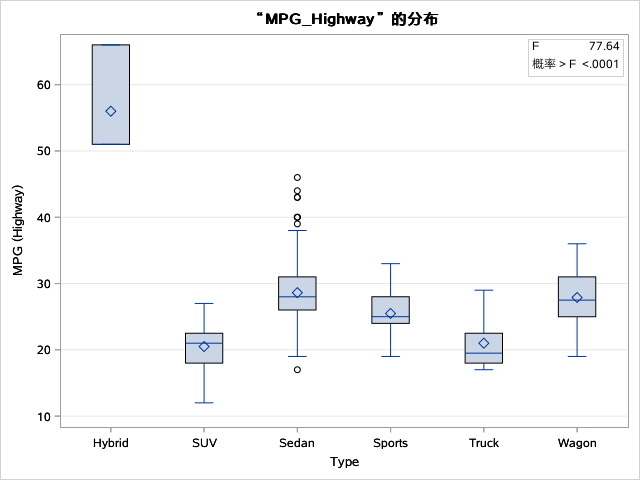
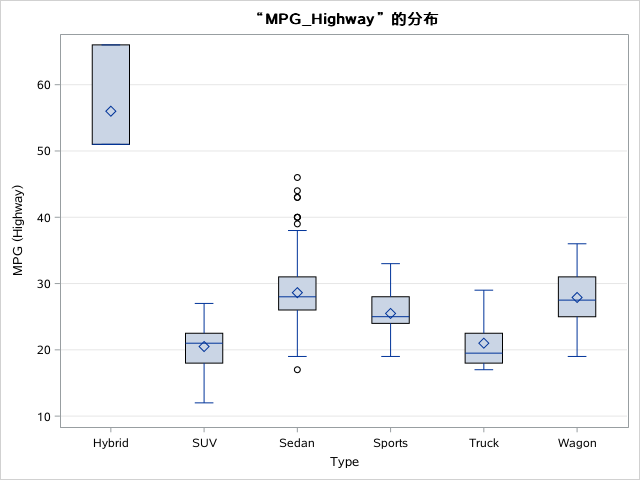
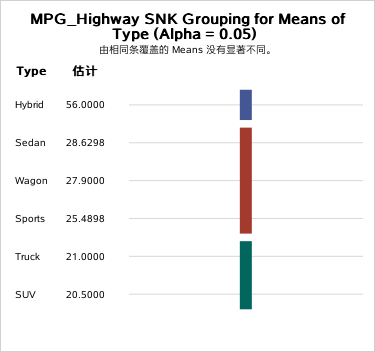

In [7]:
%%SAS
PROC ANOVA data = sashelp.cars;
    CLASS Type;
    MODEL MPG_Highway = Type;
    MEANS Type / SNK ALPHA=0.05;
run;

## glm 过程做完全随机设计资料的方差分析

`GLM` 过程步是一个通用的线性模型过程步，适用于平衡和不平衡的方差分析。它可以处理多种实验设计，包括完全随机设计、随机区组设计、拉丁方设计、析因设计等。

### 基本语法

```{sas}
PROC GLM data = 数据集 <可选项> ;
    CLASS 分类变量列表;
    MODEL 因变量 = 效应变量列表 </可选项>;
    <MEANS 效应变量列表 </可选项> ;>
    <LSMEANS 效应变量列表 </可选项> ;>
    <TEST <H=效应变量列表> E=效应变量列表;>
    <OUTPUT OUT=输出数据集 <可选项> ;>
run;
```

- `class` 语句是定义处理因素中不同水平的分组情况,称为分组变量,本例为变量 `Type`。
- `model` 语句用来指定分析变量(效应)和分组变量(自变量),两者用 `=` 相连,效应在 `=` 左侧,本例为变量 `MPG_Highway`,自变量在 `=` 右侧,本例为变量 `Type`。
- `means` 语句表示需要计算处理因素不同水平组中分析变量的均数和标准差,后面可加选项,表示对均数进行多重两两比较,并确定两两比较的方法。
- SAS 系统提供了多种两两比较的方法可供选择,如 `SNK(Student-Newman-Keuls)` 检验、最小显著差异 `(least significant difference,LSD)` *t* 检验、`Scheffe` 检验、`Dunnett` 法、`Tukey` 检验、`Duncan` 检验等,本例选择 `LSD t` 检验。


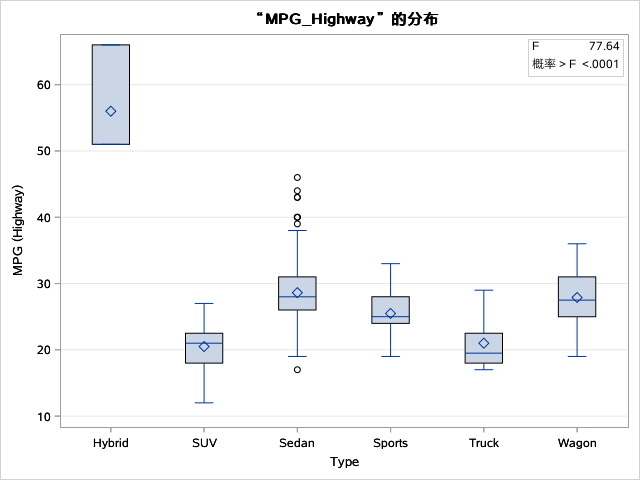
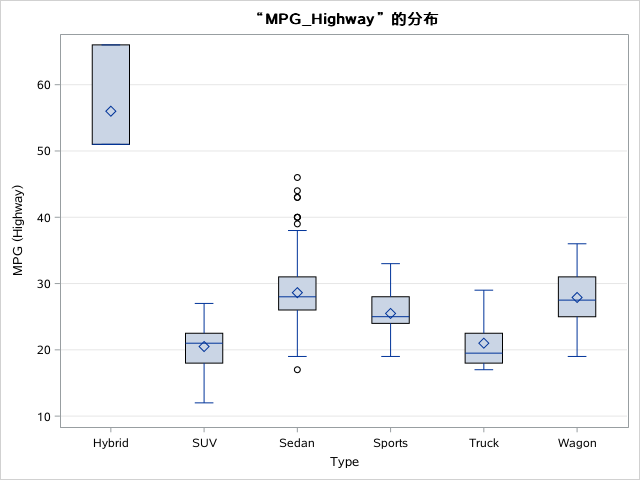
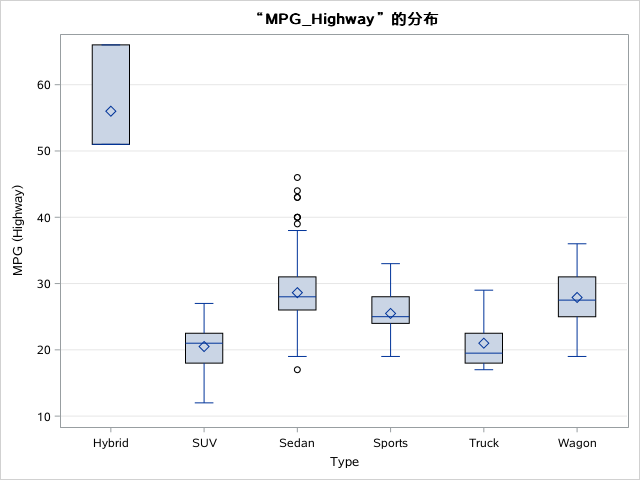

In [9]:
%%SAS
PROC GLM data = sashelp.cars;
    CLASS Type;
    MODEL MPG_Highway = Type;
    MEANS Type;
    MEANS Type / LSD ALPHA=0.05;
run;

### 两两比较采用 Dunnett 法

如果两两比较采用的是 Dunnett 检验,将程序中 `MEANS Type / LSD ALPHA=0.05;` 部分中的的 `LSD` 改为 `Dunnett` 即可.

SAS 默认分组变量中的变量值最小的组为对照组。如果在 `Dunnett` 后面加条件,可以将任何一组定义为对照组。这里选择 Sedan 为对照组,语句为:
`means c/dunnett ('Sedan');`,上述 `dunnett` 语句后面的括号内为作为对照组的变量值,该变量值需用单引号表示。


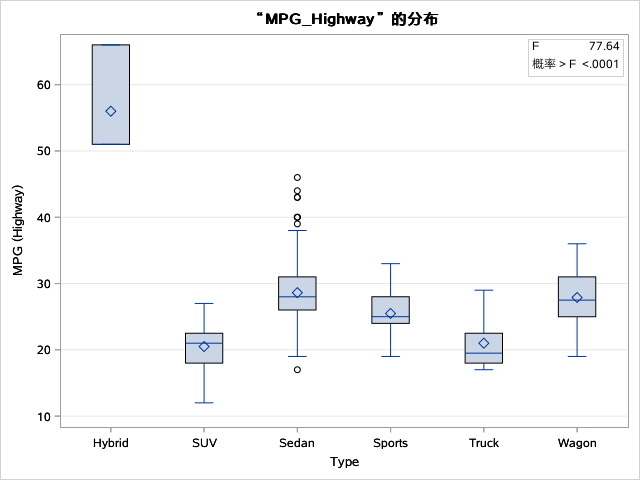
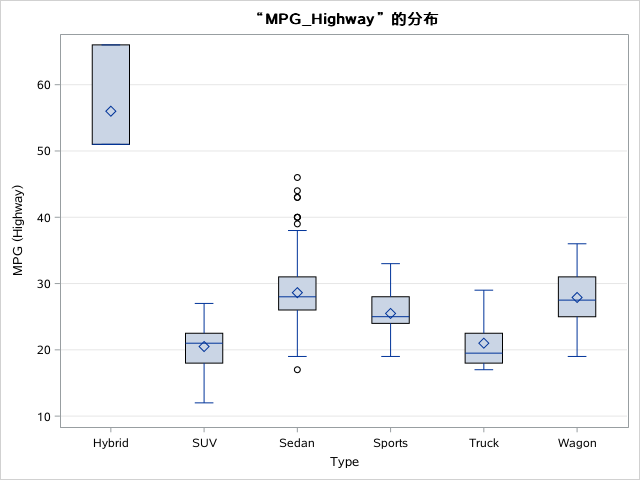
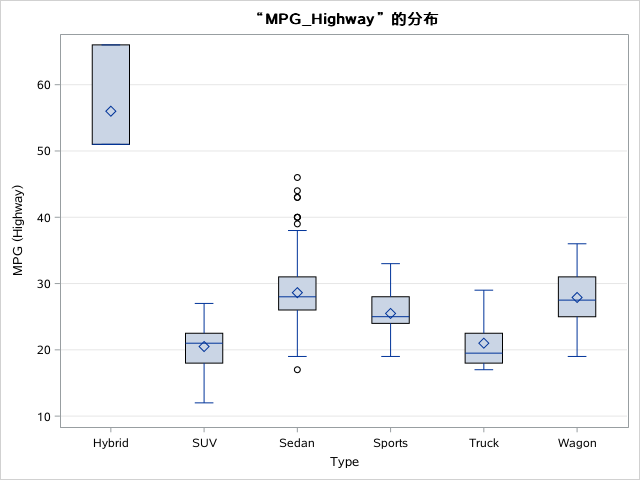

In [10]:
%%SAS
PROC GLM data = sashelp.cars;
    CLASS Type;
    MODEL MPG_Highway = Type;
    MEANS Type;
    MEANS Type / dunnett ('Sedan') ALPHA=0.05;
run;

## 随机区组设计资料的方差分析

随机区组设计又称为配伍组设计,是先将除处理因素外其他条件相同或相近的受试对象归人一个区组,再将一个区组内的受试对象随机分配
到不同的实验组内,从而保证同一个区组内的受试对象接受的处理是不同的。由于区组内各受试
对象的其他条件相同或相近,因此彼此间实验效应的差异主要是由处理因素引起的,而且处理因素和区组因素没有交互作用。

### 基本语法

其语法与完全随机设计的方差分析类似,只是在 `CLASS` 语句中增加了区组变量,并在 `MODEL` 语句中指定区组变量。

### 示例

在一项“纤维蛋白胶干粉在肝损伤模型上的止血作用”的研究中，某研究者对9个窝别的27只大鼠建立肝损伤模型，每个窝别中的3只大鼠随机接受不同的处理，即空白组、凝血酶组和纤维蛋白胶组。观测大鼠在30分钟内的失血量，数据集如下：

| 窝别 | 空白组 | 凝血酶组 | 纤维蛋白胶组 |
| --- | --- | --- | --- |
| 1 | 3.85 | 2.14 | 0.87 |
| 2 | 3.88 | 1.98 | 0.36 |
| 3 | 4.56 | 1.21 | 0.42 |
| 4 | 3.33 | 1.45 | 0.51 |
| 5 | 2.22 | 0.76 | 0.83 |
| 6 | 4.44 | 1.78 | 0.82 |
| 7 | 4.29 | 1.55 | 0.44 |
| 8 | 6.23 | 4.22 | 1.23 |
| 9 | 5.55 | 2.22 | 0.23 |

### 程序说明

- `a`：代表区组
- `b`：代表处理因素
- `do`：利用一个循环语句建立数据集
- 这里不同的止血效果相互比较用 SNK 方法


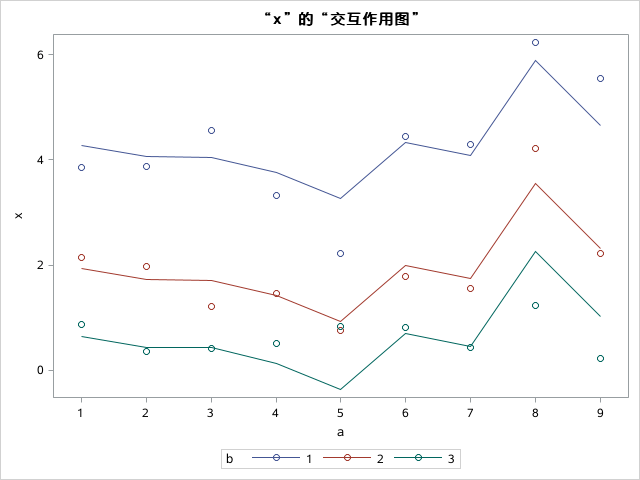
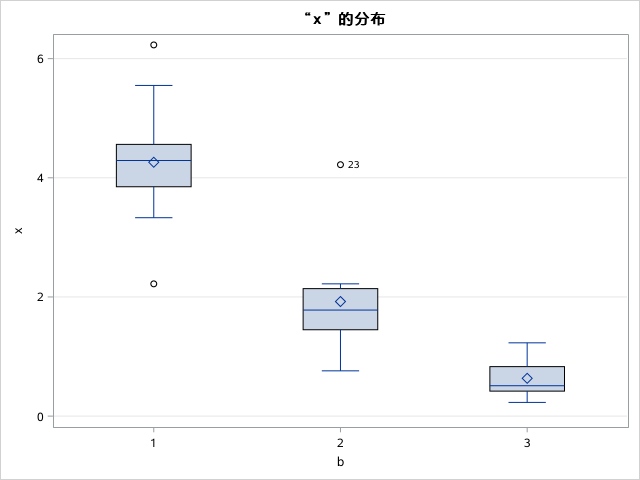
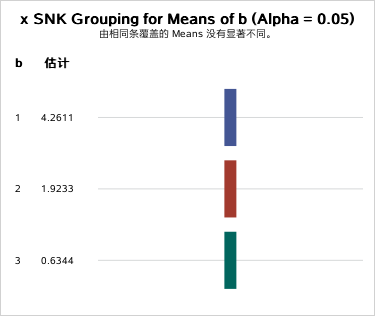

In [17]:
%%SAS
data prg11_1;
    do a = 1 to 9;
    do b = 1 to 3;
        input x @@;
        output;
    end;
end;
datalines;
3.85 2.14 0.87 3.88 1.98 0.36
4.56 1.21 0.42 3.33 1.45 0.51
2.22 0.76 0.83 4.44 1.78 0.82
4.29 1.55 0.44 6.23 4.22 1.23
5.55 2.22 0.23
;
run;
proc glm;
    class a b;
    model x= a b;
    means b/snk alpha=0.05;
run;
quit;

### 结果说明

- 结果的形式与完全随机设计资料的结果是一样的。由于随机区组设计有两个分组变量,所以在针对分组变量的方差分析表中,有两个分组变量的情况需分析。本例模型的方差分析表中的 $F= 16.80,P<0.0001$,说明模型有统计学意义。
- 区组和处理变量中,选择 Type Ⅲ SS 的结果,区组变量 a 的 $F=3.58 ,P=0.0143$,说明各区组均数之间的差异有统计学意义。
- 处理组变量 b 的 $F=69.69,P<0.0001$,说明各处理组均数之间的差异也有统计学意义。
- 多个均数两两比较 SNK 检验的结果与 LSD t 检验有些类似,只是在确定界值时的表达方式有所不同。SNK 检验比较中列出了按均数大小排序时的组数及其检验统计量的界值,分别为: Number of Means 表示组数, Critical Range 表示不同组数时的统计量的界值。

## 拉丁方设计资料的方差分析

拉丁方设计是有三个因素的设计类型,是在随机区组设计的基础上,又增加了一个已知的对实验结果有影响的因素,增加了均衡性,减少了误差,提高了实验效率。

主要用于用于控制两个额外变量（blocking factors）的影响，同时研究一个处理因素的效应。

不过,在拉丁方设计中,三个因素的水平数必须相同,而且这三个因素不存在交互作用。假设水平数为 r ,整个设计可以组成一个由 r 个拉丁字母排成 r 行 r 列的方阵,使得每行每列的每个字母都只出现一次,这样的方阵叫 r 阶拉丁方或 r*r 拉丁方。

### 拉丁方设计资料示例

| 编号（行区组） | 注射部位编号（列区组）1 | 注射部位编号（列区组）2 | 注射部位编号（列区组）3 | 注射部位编号（列区组）4 | 注射部位编号（列区组）5 | 注射部位编号（列区组）6 |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| 1 | C(87) | B(75) | E(81) | D(75) | A(84) | F(66) |
| 2 | B(73) | A(81) | D(87) | C(85) | F(64) | E(79) |
| 3 | F(73) | E(73) | B(74) | A(78) | D(73) | C(77) |
| 4 | A(77) | F(68) | C(69) | B(74) | E(76) | D(73) |
| 5 | D(64) | C(64) | F(72) | E(76) | B(70) | A(81) |
| 6 | E(75) | D(77) | A(82) | F(61) | C(82) | B(61) | 

字母 A、B、C、D、E、F 分别代表不同的药物,括号内的数字代表每个注射部位注射药物后得到的测量值。

In [19]:
%%SAS
data Latin_Square;
    do r= 1 to 6;
        do c =1 to 6;
            input z $ x @@;
            output;
        end;
    end;
datalines;
C 87 B 75 E 81 D 75 A 84 F 66
B 73 A 81 D 87 C 85 F 64 E 79
F 73 E 73 B 74 A 78 D 73 C 77
A 77 F 68 C 69 B 74 E 76 D 73
D 68 C 70 F 72 E 76 B 70 A 81
E 75 D 77 A 82 F 61 C 82 B 61
;
run;
proc glm;
    class r c z;
    model x = r c z;
run;
quit;

### 程序说明

- 使用两个 `do-end` 循环语句；
- 该数据集有四个变量, r、c 和 z 都是分组变量
- r 为行区组变量,表示编号;
- c 为列区组变量表示注射部位;
- z 为处理变量,表示注射药物;
- x 为分析变量,表示测量值大小；
- glm 过程中将三个分组因素变量放在 `=` 右侧,彼此之间用空格分隔.

### 结果说明

1. 各个分组因素的方差分析表部分都有三个分组变量的情况,分别说明三个因素的各个水平之间均数的差异是否有统计学意义。

2. 这里模型的方差分析表中的 F=2.37.P=0.0362，说明模型有统计学意义。

3. 选择查看 Type Ⅲ SS 下的结果：
- 本例 r 所对应的 F=1.42,P=0.2587,说明 6 个样本的总体均数之间差异无统计学意义;
- c 所对应的 F=0.53,P=0.747 4,说明6个注射部位皮肤疱疹大小的总体均数差异无统计学意义;
- z 所对应的 F=5.16,P=0.0033,说明6 种药物产生皮肤疱疹大小的总体均数之间差异有统计学意义。

## 两阶段交叉设计资料的方差分析

交叉设计是指受试对象在不同的实验阶段分别接受不同的处理因素,则实验效应受到三个因素的影响,一个是处理因素,一个是个体区组因素,还有一个是实验阶段因素。

虽然交叉实验的处理是单因素,但影响实验结果的因素还有非人为控制的受试者的个体差异和实验阶段这两个因素。

因此,该设计不仅平衡了处理顺序的影响而且能把处理方法间的差别、时间先后之间的差别和受试者之间的差别分别进行分析。最简单的交叉设计是处理因素的水平数为 2,而处理顺序因素和实验阶段因素的水平数都为 2。

### 两阶段交叉设计资料示例

某研究者为研究A、B两种方案治疗12名高血压患者的疗效，随机让1、2、5、8、9、10号患者第一阶段先用A 法治疗，第二阶段后用B法治疗；3、4、6、7、11、12号患者第一阶段先用B法治疗，第二阶段后用A法治疗,记录治疗后收缩压的下降值。

试分析A、B 两种方案治疗高血压的疗效有无差异。

A、B两种方案收缩压下降值（mmHg）

| 阶段 | 患者编号1 | 患者编号2 | 患者编号3 | 患者编号4 | 患者编号5 | 患者编号6 | 患者编号7 | 患者编号8 | 患者编号9 | 患者编号10 | 患者编号11 | 患者编号12 |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| I | A | A | B | B | A | B | B | A | A | A | B | B |
| I | 17.6 | 28.0 | 10.3 | 14.0 | 24.4 | 17.0 | 15.1 | 26.0 | 30.2 | 31.8 | 14.0 | 17.5 |
| II | B | B | A | A | B | A | A | B | B | B | A | A |
| II | 13.0 | 12.6 | 20.0 | 27.0 | 13.4 | 23.0 | 26.0 | 13.0 | 18.9 | 28.0 | 19.4 | 21.2 | 

In [21]:
%%SAS
data cross_over;
    do time = 1 to 2;
        do r = 1 to 12;
            input treat $ x @@;
            output;
        end;
    end;
datalines;
A 17.6 A 28.0 B 10.3 B 14.0 A 24.4 B 17.0 B 15.1 A 26.0 A 30.2 A 31.8 B 14.0 B 17.5
B 13.0 B 12.6 A 20.0 A 27.0 B 13.4 A 23.0 A 26.0 B 13.0 B 18.9 B 28.0 A 19.4 A 21.2
;
run;
proc glm;
    class r time treat;
    model x = r time treat;
run;
quit;

### 程序说明

- 数据集 `cross_over` 中的变量 `r` 代表受试者编号;
- 变量 `time` 为实验阶段,1 表示第 I 阶段,2表示第 Ⅱ 阶段;
- `treat` 为治疗方法编号,A 表示 A 疗法,B 表示 B 疗法。

### 结果说明

- 交叉设计的方差分析结果与拉丁方的结果完全一样。
- 本例模型的方差分析结果为: F=7.47,P<0.0016,说明模型有统计学意义。
- 选择 Type Ⅲ SS 结果显示,`r` 所对应的 F=3.72,P<0.0238,说明不同受试者的治疗后收缩压下降值的均数之间的差异有统计学意义;
- `time` 所对应的 F=0.52,P=0.4879,说明不同试验阶段之间的差异无统计学意义;
- `teat` 所对应的 F=55.72,P<0.0001,说明两种治疗方式所造成的收缩压下降值之间的差异有统计学意义。

## 析因设计资料的方差分析

前四种设计方法都是只涉及每一个处理因素对实验效应的影响,而在析因设计中不仅可以考虑每一个处理因素对实验效应的主效应,还可以对两个或更多处理因素的交互作用进行分析。

在析因设计实验中将各因素的所有水平相互交叉进行组合,每种组合看作一种处理,然后在每种处理中进行实验;对研究中的每个因素只需要较少的实验对象，就可以提供较多的信息以提高试验的效率。

### 两因素两水平的析因分析

在两因素两水平的析因设计中,每个因素有两个水平,每个处理组有两个因素的所有组合,即 2*2=4 个处理组。

### 示例

| A（饲料盐含量） | 高盐饲料（$a_1$）  | 高盐饲料（$a_1$） | 正常盐饲料（$a_2$） | 正常盐饲料（$a_2$）  |
| ---- | ---- | ---- | ---- | ---- |
| B（CSSN 变性）| 是（$b_1$）|  否（$b_2$）|  是（$b_1$）| 否（$b_2$）|
| 1 | 0.47 | 0.16 | 1.09 | 0.31 |
| 2 | 0.51 | 0.12 | 1.15 | 0.54 |
| 3 | 0.23 | 0.17 | 0.51 | 0.50 |
| 4 | 0.36 | 0.11 | 0.51 | 0.38 |
| 5 | 0.32 | 0.15 | 0.20 | 0.66 |
| 6 | 0.42 | 0.28 | 0.68 | 0.93 |
| 7 | 0.18 | 0.09 | 1.38 | 0.65 |
| 8 | 0.28 | 0.27 | 0.57 | 0.41 |
| 9 | 0.26 | 0.16 | 1.38 | 0.28 | 

In [22]:
%%SAS
data factorial;
    input x a b @@;
datalines;
0.47 1 1 0.51 1 1 0.23 1 1
0.36 1 1 0.32 1 1 0.42 1 1
0.18 1 1 0.28 1 1 0.26 1 1
0.16 1 2 0.12 1 2 0.17 1 2
0.11 1 2 0.15 1 2 0.28 1 2
0.09 1 2 0.27 1 2 0.16 1 2
1.09 2 1 1.15 2 1 0.51 2 1
0.51 2 1 0.2 2 1 0.68 2 1
1.38 2 1 0.57 2 1 1.38 2 1
0.31 2 2 0.54 2 2 0.5 2 2
0.38 2 2 0.66 2 2 0.93 2 2
0.65 2 2 0.41 2 2 0.28 2 2
;
proc anova;
    class a b;
    model x = a b a*b;
quit;

### 程序说明

- 数据集 factorial 中变量 a 表示饲料盐含量,其变量值有两个水平,1 代表高盐饲料,2 代表正常盐饲料;
- 变量 b 表示CSSN 变性,其变量值 1 代表变性,2 代表未变性;
- 变量 x 表示不同组合下每次试验的 ALD 浓度。
- 在 `glm` 过程中定义模型类型时,用 `*` 表示两因素的交互作用,析因设计考虑 a 因素和 b 因素的交互作用。

### 结果说明

- 本例模型的方差分析结果为 F=11.91,P<0.0001,说明模型有统计学意义。
- 根据 Type Ⅲ SS 结果显示,A 因素所对应的 F=26.38,P<0.0001,说明饲料盐含量对大鼠血浆中ALD浓度有影响；
- B 因素对应的 F=8.58,P=0.0062,说明CSSN 变性与否对大鼠血浆中 ALD 浓度有影响;
- 两种因素的交互项 A*B 的 F=0.76,P=0.3892,尚不能认为两种因素有交互作用。

### 两因素三水平的析因分析

在两因素三水平的析因设计中,每个因素有三个水平,每个处理组有两个因素的所有组合,即 3*3=9 个处理组。

### 示例

| A药物剂量 | B药物剂量5μg | B药物剂量15μg | B药物剂量30μg |
| ---- | ---- | ---- | ---- |
| 1.0 mg | 105 | 115 | 75 |
|  1.0 | 80 | 105 | 95 |
|  2.0 | 65 | 80 | 85 |
| 2.5 mg | 75 | 125 | 135 |
|  2.5 | 115 | 130 | 120 |
|  2.5 | 80 | 90 | 150 |
| 5.0 mg | 85 | 65 | 180 |
|  2.5 | 120 | 120 | 190 |
|  2.5 | 125 | 100 | 160 | 

In [2]:
%%SAS
data prg233;
    input x a b @@;
cards;
65 1 1 80 1 1 65 1 1 75 2 1
115 2 1 80 2 1 85 3 1 120 3 1
125 3 1 115 1 2 105 1 2 80 1 2
125 2 2 130 2 2 90 2 2 65 3 2
120 3 2 100 3 2 75 1 3 95 1 3
85 1 3 135 2 3 120 2 3 150 2 3
180 3 3 190 3 3 160 3 3
;
proc anova;
    class a b;
    model x=a b a*b;
quit;

Using SAS Config named: winlocal
SAS Connection established. Subprocess id is 2836



### 三因素不同水平的析因设计

In [3]:
%%SAS
data prg522;
do a = 1 to 5;
    do b = 1 to 2;
        do c = 1 to 2;
            do i = 1 to 5;
                input x @@;
                output;
            end;
        end;
    end;
end;
datalines;
0.25 -0.25 1.25 -0.75 0.40 4.75 3.45 4.00 4.85 4.55 
0.50 2.10 2.75 1.00 2.35 3.75 4.00 4.00 4.25 4.60 
0.30 0.10 0.50 -0.35 0.05 4.60 4.80 4.00 5.20 4.30 
1.50 1.50 1.25 1.37 2.55 4.00 4.05 4.15 4.10 4.25 
0.75 -0.50 0.60 0.40 -0.20 4.55 3.50 4.25 4.10 4.40 
0.75 2.65 3.00 0.05 1.17 4.10 5.00 4.20 4.15 4.17 
0.20 -1.00 0.85 -0.50 0.90 4.25 3.10 4.00 5.00 4.20 
-0.75 0.90 0.95 0.62 1.05 3.27 4.25 4.00 4.25 4.25 
-0.10 0.00 2.50 0.10 -0.10 4.72 4.30 4.10 4.80 3.60 
1.75 2.40 1.75 3.05 2.75 4.80 4.02 4.15 4.75 4.80
;
run;
proc glm;
    class a b c;
    model x = a b c a*b a*c b*c a*b*c;
run;
quit;

## 正交设计资料的方差分析

析因设计的缺点是当因素比较多或者各个因素中的水平数较多时,所需的实验单位数、处理组数、方差分析的计算量剧增,实现起来会很困难。此时可选择正交设计。正交设计并不考虑所有水平的交互作用,只考虑部分重要因素的一级交互作用。在作正交设计时,要根据具体情况选择合适的正交表。

### 正交设计资料示例

在某研究中,研究者对影响某种鱼类产卵数量的因素进行实验,设计了一个正交实验。实验因素包括 A、B、C、D 四个因素,每个因素有两个水平。

| 实验序号 | A因素温度/℃ | B因素含氧量/% | C因素含水量/% | D因素pH | 产卵数量 |
| ---- | ---- | ---- | ---- | ---- | ---- |
| 1 | 5 | 0.5 | 10 | 6.0 | 86 |
| 2 | 5 | 0.5 | 30 | 8.0 | 95 |
| 3 | 5 | 5.0 | 10 | 8.0 | 91 |
| 4 | 5 | 5.0 | 30 | 6.0 | 94 |
| 5 | 25 | 0.5 | 10 | 8.0 | 91 |
| 6 | 25 | 0.5 | 30 | 6.0 | 96 |
| 7 | 25 | 5.0 | 10 | 6.0 | 83 |
| 8 | 25 | 5.0 | 30 | 8.0 | 90 |

In [5]:
%%SAS
data Orthogonal;
    input a b c d x @@;
datalines;
5 0.5 10 6.0 86 
5 0.5 30 8.0 95 
5 5.0 10 8.0 91 
5 5.0 30 6.0 94 
25 0.5 10 8.0 91 
25 0.5 30 6.0 96 
25 5.0 10 6.0 83 
25 5.0 30 8.0 90
;
run;
proc glm;
    class a b c d;
    model x = a b c d a*b;
run;
quit;

## glm 语句的常用选项和过程

### glm 过程的基本格式

```sas
proc glm<选项>;
    class 变量;
    model 应变量 = 自变量;
    absorb 变量;
    by 变量;
    freq 变量;
    id 变量;
    weight 变量;
    contrast '标签' 效应值 <…效应值> </ 选项 >;
    estimate '标签' 效应值 <…效应值> </ 选项 >
    Ismeans 分类或处理变量 </ 选项>;
    manova <检验方法选项> </ 其他细节选项 >:
    means 分类或处理变量 </ 选项>;
    output <out=数据集名称> 输出变量 = 定义变量名称 <...输出变量 = 定义变量名称> </ 选项 >;
    random 随机效应变量 </ 选项 >;
    repeated 重复因子 </ 选项 >;
    test <h= 效应变量 > t = 效应误差项 </ 选项 >;
run;
```

### glm 过程的常用选项

1. `alpha=value` 选项 将设置一个为 0~1 之间的任意值作为概率值(value),也可用于指定统计量置信区间的置信水平,默认值为 0.05.
2. `plots=boxplot` 选项 用于产生箱式图(boxplot),使用时必需先通过 `ods graphics on` 语句启用 `ods` 图形,才能进行绘图。完整语句可参考如下:

```sas
ods graphics on;
proc glm plots = boxplot;
    class c;
    model x = c;
    means c;
    means c/lsd;
run;
quit;
ods graphics off;
```


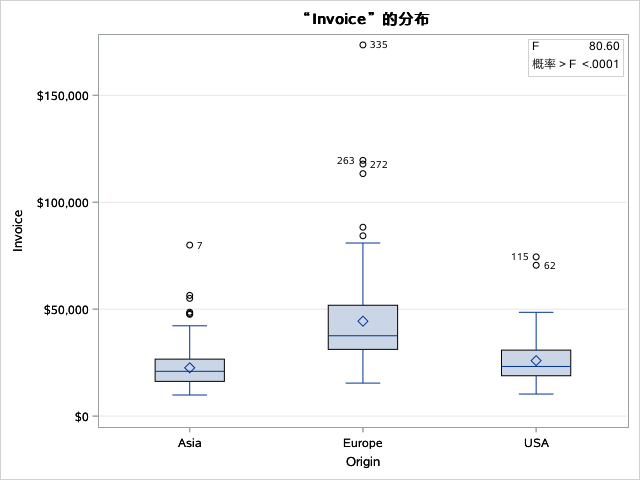
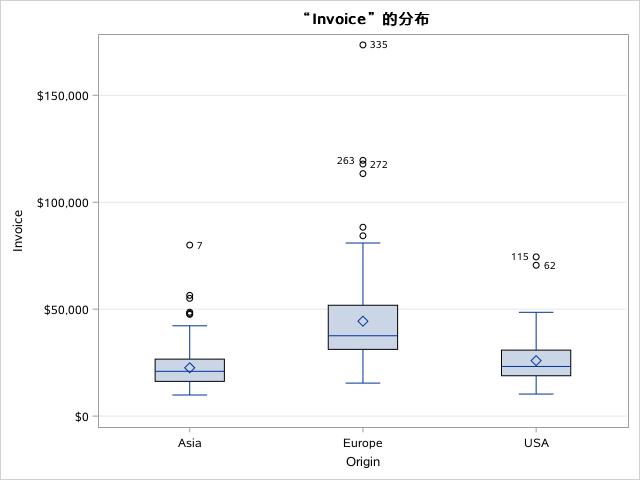
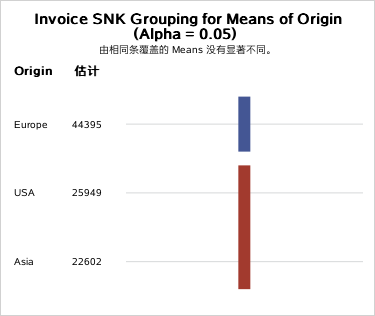

In [8]:
%%SAS
ods graphics on;

/* 修正数据集名称和数据步语法 */
proc glm data=sashelp.cars plots(only)=boxplot;
    class Origin;
    model Invoice = Origin;
    
    /* 仅保留一种多重比较方法（SNK法） */
    means Origin / SNK ALPHA=0.05;
    
    /* 输出方差分析表 */
    output out=residuals predicted=pred residual=resid;
run;
quit;
ods graphics off;

### glm 过程的常用语句

1. `by` 语句 用于按照某个变量的不同取值,分别进行 `glm` 过程分析。
2. `means` 变量`/hovtest`选项 该选型可用于检验方差齐性,可以指定以下方法用于检验方差产性: `hovtest=bartlett`, `hovtest=bf`, `hovtest=levene`,`hovtest=obrien`,默认的检验方法为 `levene`。注意,该选项一般用于完全随机设计的方差分析中。
3. `means` 变量`/bon`选项 除文中所提及的多重比较方法之外,常用的还有 `bonferroni t` 检验,须在 `means` 后面选项中指明。
4. `means` 变量`/cldif`选项 该选项用于两两比较的结果以置信区间的形式展现。可在 `means c/lsd` 后面加上 `cldiff`,变为 `means c/lsd cldif`,可以得到如下两两比较的结果展现形式:


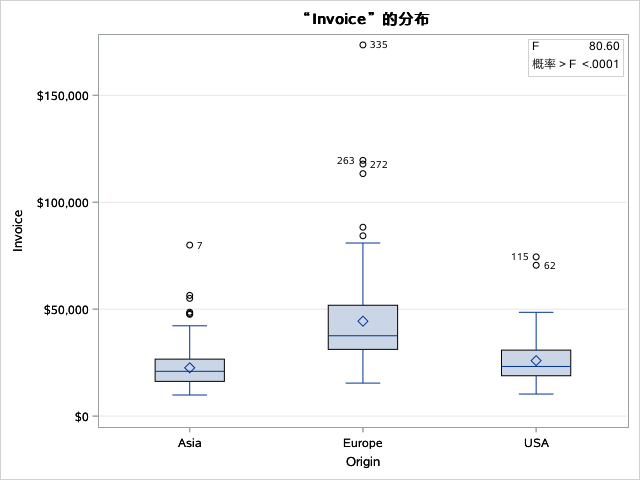
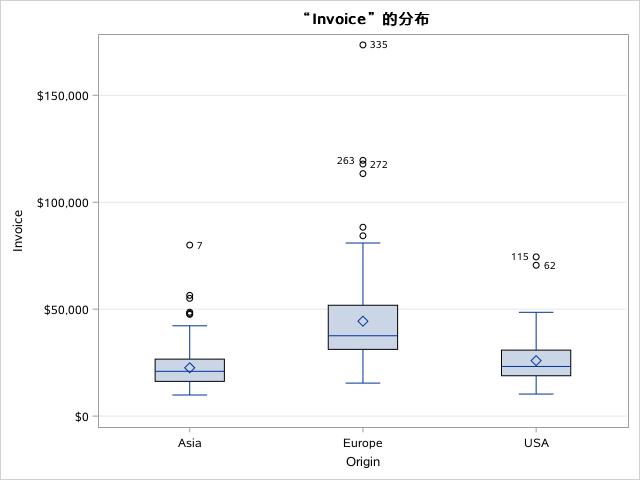

In [9]:
%%SAS
ods graphics on;

/* 修正数据集名称和数据步语法 */
proc glm data=sashelp.cars plots(only)=boxplot;
    class Origin;
    model Invoice = Origin;
    
    /* 仅保留一种多重比较方法（SNK法） */
    means Origin / lsd cldif ALPHA=0.05;
    
    /* 输出方差分析表 */
    output out=residuals predicted=pred residual=resid;
run;
quit;
ods graphics off;